# Graph Neural Network- GNN

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [64]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [65]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'networkx': '2.6.2',
    'numpy': '1.21.2',
}

check_packages(d)

ModuleNotFoundError: No module named 'python_environment_check'

# Chapter 18 - Graph Neural Networks for Capturing Dependencies in Graph Structured Data (Part 1/2)

- [Introduction to graph data](#Introduction-to-graph-data)
  - [Undirected graphs](#Undirected-graphs)
  - [Directed graphs](#Directed-graphs)
  - [Labeled graphs](#Labeled-graphs)
  - [Representing molecules as graphs](#Representing-molecules-as-graphs)
- [Understanding graph convolutions](#Understanding-graph-convolutions)
  - [The motivation behind using graph convolutions](#The-motivation-behind-using-graph-convolutions)
  - [Implementing a basic graph convolution](#Implementing-a-basic-graph-convolution)
- [Implementing a GNN in PyTorch from scratch](#Implementing-a-GNN-in-PyTorch-from-scratch)
  - [Defining the NodeNetwork model](#Defining-the-NodeNetwork-model)
  - [Coding the NodeNetwork’s graph convolution layer](#Coding-the-NodeNetworks-graph-convolution-layer)
  - [Adding a global pooling layer to deal with varying graph sizes](#Adding-a-global-pooling-layer-to-deal-with-varying-graph-sizes)
  - [Preparing the DataLoader](#Preparing-the-DataLoader)
  - [Using the NodeNetwork to make predictions](#Using-the-NodeNetwork-to-make-predictions)

In [ ]:
from IPython.display import Image
%matplotlib inline

## Introduction to graph data

In [ ]:
Image(filename='figures/18_01.png', width=500)

### Undirected graphs

In [ ]:
Image(filename='figures/18_02.png', width=500)

### Directed graphs

In [ ]:
Image(filename='figures/18_03.png', width=300)

### Labeled graphs

### Representing molecules as graphs

In [ ]:
Image(filename='figures/18_04.png', width=500)

### Understanding graph convolutions

### The motivation behind using graph convolutions

In [ ]:
Image(filename='figures/18_05.png', width=500)

### Implementing a basic graph convolution

In [ ]:
Image(filename='figures/18_06.png', width=500)

In [ ]:
import networkx as nx
import numpy as np
import scipy


In [ ]:
G = nx.Graph()

#Hex codes for colors if we draw graph
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"

G.add_nodes_from([(1, {"color": blue}),
                  (2, {"color": orange}),
                  (3, {"color": blue}),
                  (4, {"color": green})])

G.add_edges_from([(1, 2),(2, 3),(1, 3),(3, 4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

In [ ]:
def build_graph_color_label_representation(G,mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in 
                             nx.get_node_attributes(G, 'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size,len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size),one_hot_idxs] = 1
    return one_hot_encoding

X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)
X.shape[1]

In [ ]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels=True, node_color=color_map)

In [ ]:
Image(filename='figures/18_07.png', width=800)

In [ ]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out) 
W_2 = np.random.rand(f_in, f_out) 
h = np.dot(X,W_1) + np.dot(np.dot(A, X), W_2)

In [ ]:
Image(filename='figures/18_08.png', width=500)

## Implementing a GNN in PyTorch from scratch

### Defining the NodeNetwork model

In [ ]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F

In [ ]:
class NodeNetwork(torch.nn.Module):

    def __init__(self, input_features):
        super().__init__()
        
        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)
    
    def forward(self, X, A,batch_mat):
        x = self.conv_1(X, A).clamp(0)
        x = self.conv_2(x, A).clamp(0)
        output = global_sum_pool(x, batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)

In [ ]:
Image(filename='figures/18_09.png', width=700)

### Coding the NodeNetwork’s graph convolution layer

In [ ]:
class BasicGraphConvolutionLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.W2 = Parameter(torch.rand(
             (in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand(
             (in_channels, out_channels), dtype=torch.float32))
         
        self.bias = Parameter(torch.zeros(
                 out_channels, dtype=torch.float32))
    
    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

### Adding a global pooling layer to deal with varying graph sizes

In [ ]:
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

In [ ]:
Image(filename='figures/18_10.png', width=600)

In [ ]:
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx]+graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1
    return batch_mat

In [ ]:
def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    # create batch matrix
    batch_mat = get_batch_tensor(sizes)
    # combine feature matrices
    feat_mats = torch.cat([graph['X'] for graph in batch],dim=0)
    # combine labels
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    # combine adjacency matrices
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
        accum = accum + g_size
    repr_and_label = {
            'A': batch_adj, 
            'X': feat_mats,
            'y': labels,
            'batch' : batch_mat}

    return repr_and_label

### Preparing the DataLoader

In [ ]:
def get_graph_dict(G, mapping_dict):
    # build dictionary representation of graph G
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation() was introduced with the first example graph
    X = torch.from_numpy(build_graph_color_label_representation(G,mapping_dict)).float()
    # kludge since there is not specific task for this example
    y = torch.tensor([[1, 0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}
    
# building 4 graphs to treat as a dataset

blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict = {green: 0, blue: 1, orange: 2}

G1 = nx.Graph()
G1.add_nodes_from([(1, {"color": blue}),
                   (2, {"color": orange}),
                   (3, {"color": blue}),
                   (4, {"color": green})])
G1.add_edges_from([(1, 2), (2, 3),(1, 3), (3, 4)])
G2 = nx.Graph()
G2.add_nodes_from([(1, {"color": green}),
                   (2, {"color": green}),
                   (3, {"color": orange}),
                   (4, {"color": orange}),
                   (5,{"color": blue})])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])
G3 = nx.Graph()
G3.add_nodes_from([(1, {"color": orange}),
                   (2, {"color": orange}),
                   (3, {"color": green}),
                   (4, {"color": green}),
                   (5, {"color": blue}),
                   (6, {"color":orange})])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])
G4 = nx.Graph()
G4.add_nodes_from([(1, {"color": blue}), (2, {"color": blue}), (3, {"color": green})])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [get_graph_dict(graph,mapping_dict) for graph in [G1, G2, G3, G4]]

In [ ]:
Image(filename='figures/18_11.png', width=600)

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class ExampleDataset(Dataset):
    
    # Simple PyTorch dataset that will use our list of graphs
    def __init__(self, graph_list):
        self.graphs = graph_list
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self,idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [ ]:
dset = ExampleDataset(graph_list)
# Note how we use our custom collate function
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

### Using the NodeNetwork to make predictions

In [ ]:
torch.manual_seed(123)
node_features = 3
net = NodeNetwork(node_features)

In [ ]:
batch_results = []

for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

G1_rep = dset[1]
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()

G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

# Example: Node classification in citation network

The Cora dataset is a benchmark citation network widely used in graph machine learning and graph neural network research. It consists of 2,708 nodes representing scientific publications and 5,429 edges denoting citation relationships between papers. Each node is described by a 1,433-dimensional binary feature vector indicating the presence or absence of specific words in the paper, and each node belongs to one of seven research topic classes. The dataset is provided as a single, fixed graph with predefined training, validation, and test splits, making it especially suitable for semi-supervised node classification tasks. Cora is commonly used to evaluate algorithms such as Graph Convolutional Networks (GCNs) due to its moderate size, sparse structure, and well-understood characteristics. In the PyTorch Geometric Planetoid version of the Cora dataset, node features are provided as indexed binary vectors without explicit names, although each feature actually corresponds to the presence of a specific word from the original paper vocabulary.

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

cora_dataset = Planetoid(root="Cora_data", name="Cora", transform=NormalizeFeatures())


In [2]:
print(len(cora_dataset))
data = cora_dataset[0]
print(cora_dataset)
print(data)

1
Cora()
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [3]:
# ===== Cora Dataset Inspection (PyTorch Geometric) =====
print("===== GRAPH SUMMARY =====")
print(data)
print()

print("===== BASIC STATISTICS =====")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Is undirected: {data.is_undirected()}")
print(f"Number of Feature: {data.num_features}")

print()

print("===== NODE FEATURES =====")
print(f"Feature matrix shape: {data.x.shape}")
print(f"Number of node features: {cora_dataset.num_node_features}")
print(f"First node feature vector:\n{data.x[0]}")
print()

print("===== LABELS =====")
print(f"Label tensor shape: {data.y.shape}")
print(f"Number of classes: {cora_dataset.num_classes}")
print()

print("===== DATA SPLITS =====")
print(f"Training nodes: {int(data.train_mask.sum())}")
print(f"Validation nodes: {int(data.val_mask.sum())}")
print(f"Test nodes: {int(data.test_mask.sum())}")
print()

print("===== CLASS DISTRIBUTION =====")
for c in range(cora_dataset.num_classes):
    count = int((data.y == c).sum())
    print(f"Class {c}: {count} nodes")
print()

print("===== EDGE INFORMATION =====")
print(f"Edge index shape: {data.edge_index.shape}")
print("First 10 edges:")
print(data.edge_index[:, :10])


===== GRAPH SUMMARY =====
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

===== BASIC STATISTICS =====
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Is undirected: True
Number of Feature: 1433

===== NODE FEATURES =====
Feature matrix shape: torch.Size([2708, 1433])
Number of node features: 1433
First node feature vector:
tensor([0., 0., 0.,  ..., 0., 0., 0.])

===== LABELS =====
Label tensor shape: torch.Size([2708])
Number of classes: 7

===== DATA SPLITS =====
Training nodes: 140
Validation nodes: 500
Test nodes: 1000

===== CLASS DISTRIBUTION =====
Class 0: 351 nodes
Class 1: 217 nodes
Class 2: 418 nodes
Class 3: 818 nodes
Class 4: 426 nodes
Class 5: 298 nodes
Class 6: 180 nodes

===== EDGE INFORMATION =====
Edge index shape: torch.Size([2, 10556])
First 10 edges:
tensor([[ 633, 1862, 2582,    2,  652,  654,    1,  332, 1454, 1666],
        [   0,    0,    0,    1,    1,    1,    2,    2,    2,   

## Manual label mapping based on original Cora dataset documentation
 Note: PyTorch Geometric does not expose the official label-name mapping

In [4]:

label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"
}

{np.int64(3): 818, np.int64(4): 426, np.int64(0): 351, np.int64(2): 418, np.int64(1): 217, np.int64(5): 298, np.int64(6): 180}


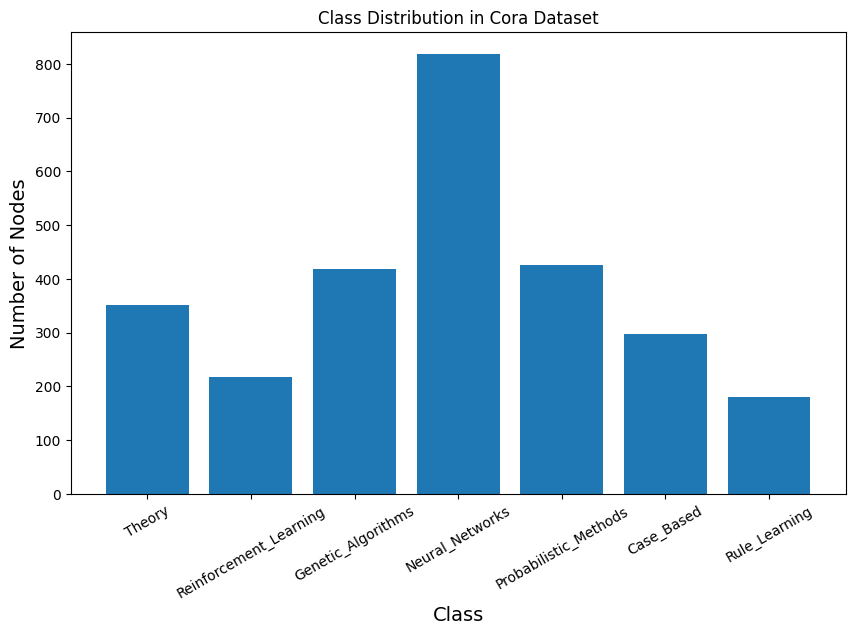

In [5]:
import collections
import matplotlib.pyplot as plt


# Count class occurrences
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)

# Sort by class index
classes = sorted(counter.keys())
counts = [counter[c] for c in classes]
labels = [label_dict[c] for c in classes]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Nodes", fontsize=14)
plt.xticks(rotation=30)
plt.title("Class Distribution in Cora Dataset")
plt.show()


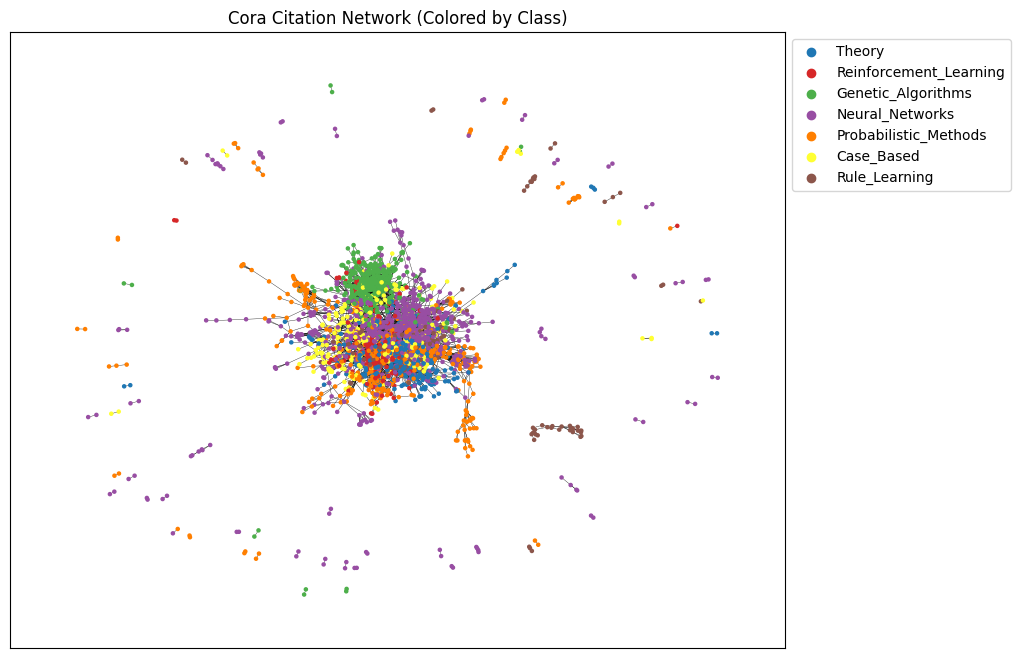

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx


# Color palette (one per class)
colorlist = [
    "#1f77b4", "#d62728", "#4daf4a",
    "#984ea3", "#ff7f00", "#ffff33", "#8c564b"
]

# Convert PyG graph to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Assign node colors based on labels
node_colors = [colorlist[int(label)] for label in data.y]

# Layout
pos = nx.spring_layout(G, seed=42)


# Prepare node colors
node_colors = [colorlist[int(label)] for label in data.y]

# Layout
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=0.25)

# Legend (explicit index-based mapping)
for i in range(len(label_dict)):
    plt.scatter([], [], c=colorlist[i], label=label_dict[i])

plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Cora Citation Network (Colored by Class)")
plt.show()


## Two-layer Graph Convolutional Network (GCN) 

The follwoing two-layer Graph Convolutional Network (GCN) takes node features and graph connectivity as input, learns hidden node representations through neighborhood aggregation, and outputs class logits for each node, where the number of output channels corresponds to the number of target classes in the dataset.
The GCN class defines a simple two-layer Graph Convolutional Network used for node classification on graph-structured data such as the Cora citation network. The `__init__` method initializes the model by setting a fixed random seed for reproducibility and defining two graph convolution layers: the first layer (`conv1`) transforms the input node features into a lower-dimensional hidden representation, while the second layer (`conv2`) maps these hidden representations to the final output space, whose size equals the number of target classes. In the forward method, the model receives a graph object containing node features (`x`) and edge information (`edge_index`), applies the first graph convolution followed by a ReLU activation to introduce non-linearity, and then uses dropout to reduce overfitting during training. Finally, the second graph convolution produces a matrix of output scores (`logits`) for each node, which are later used with a loss function such as cross-entropy to train the model for node classification.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=16):
        super().__init__()
        torch.manual_seed(123)

        self.conv1 = GCNConv(in_channels=input_channels, out_channels=hidden_channels)
        self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=output_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        return x

model = GCN(
    input_channels=cora_dataset.num_node_features,
    output_channels=cora_dataset.num_classes,
    hidden_channels=16
)
print(model)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [8]:
model.eval()
with torch.no_grad():
    out = model(data)

print("out:", out.shape, out.dtype, out.device)
print("labels:", data.y.shape, data.y.dtype, data.y.device)


out: torch.Size([2708, 7]) torch.float32 cpu
labels: torch.Size([2708]) torch.int64 cpu


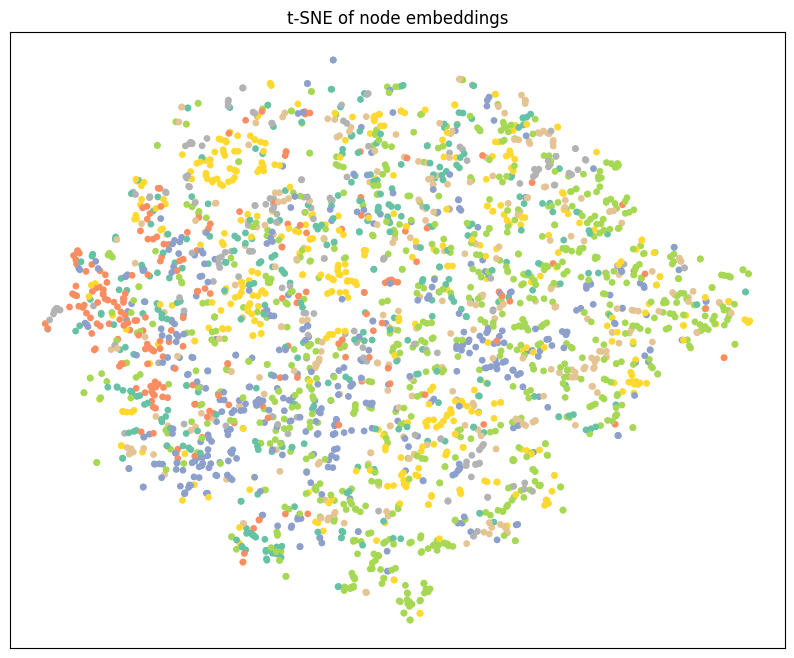

In [9]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def visualize_tsne(emb, labels, seed=42):
    X = emb.detach().cpu().numpy().astype(np.float32)
    y = labels.detach().cpu().numpy()

    n = X.shape[0]
    perplexity = min(30, max(5, (n - 1) // 3))

    tsne = TSNE(
        n_components=2,
        init="pca",
        learning_rate="auto",
        perplexity=perplexity,
        random_state=seed,
        method="barnes_hut",
        angle=0.5
    )

    Z = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(Z[:, 0], Z[:, 1], s=15, c=y, cmap="Set2")
    plt.title("t-SNE of node embeddings")
    plt.show()

# Run safely
model.eval()
with torch.no_grad():
    out = model(data)

visualize_tsne(out, data.y)


The following code initializes the main components required to train a Graph Convolutional Network (GCN) for node classification. First, the GCN model is created by specifying the number of input channels (equal to the number of node features) and output channels (equal to the number of classes), and then moved to the chosen computation device (CPU or GPU) using .to(device). Next, the Adam optimizer is defined, which updates the model parameters during training; the learning rate controls how large each update step is, while weight decay acts as a regularization term to reduce overfitting. Finally, the loss function is set to CrossEntropyLoss, which is the standard choice for multi-class classification problems and compares the model’s predicted class scores (logits) with the true node labels. Together, these components prepare the model for the training loop, where the optimizer minimizes the loss by adjusting the GCN’s weights.

In [ ]:
import torch
import torch.nn as nn

# input_channels = dataset.num_node_features
# output_channels = dataset.num_classes
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(
    input_channels=cora_dataset.num_node_features,
    output_channels=cora_dataset.num_classes,
    hidden_channels=16)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4
)

criterion = nn.CrossEntropyLoss()


The following code implements the training loop for a Graph Convolutional Network (GCN) on the Cora dataset. First, the number of training epochs is set, which determines how many times the model will see the entire graph during training. The graph data is then moved to the chosen device (CPU or GPU) so that computations are performed consistently.

Inside the loop, `model.train()` puts the network in training mode, enabling behaviors such as dropout. At the start of each epoch, existing gradients are cleared using `optimizer.zero_grad()` to prevent accumulation from previous updates. The model then performs a forward pass on the full graph, producing class scores for every node.

The loss is computed only on the training nodes using train_mask, which is important in semi-supervised learning because labels are available for only a subset of nodes. After computing the loss, `loss.backward()` calculates gradients with respect to the model parameters, and `optimizer.step()` updates those parameters to reduce the loss.

Finally, the code calculates training accuracy by comparing the predicted class of each training node with its true label. Printing the loss and accuracy every few epochs allows students to monitor whether the model is learning and improving over time.

In [ ]:
# Training settings
num_epochs = 200

# Move graph to device
cora_graph = cora_dataset[0]

for epoch in range(num_epochs):
    model.train()

    # Reset gradients
    optimizer.zero_grad()

    # Forward pass
    out = model(cora_graph)

    # Compute loss on training nodes only
    loss = criterion(
        out[cora_graph.train_mask],
        cora_graph.y[cora_graph.train_mask]
    )

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Training accuracy
    pred_train = out.argmax(dim=1)
    correct_train = (
        pred_train[cora_graph.train_mask]
        == cora_graph.y[cora_graph.train_mask]
    ).sum()

    acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

    # Print progress
    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {loss.item():.4f} | "
            f"Train Accuracy: {acc_train:.4f}"
        )


The following code evaluates the trained Graph Convolutional Network on the test portion of the dataset, which contains nodes that were not used during training. The call to `model.eval()` puts the network into evaluation mode, ensuring that layers such as dropout behave correctly and do not introduce randomness during testing.

The with `torch.no_grad()`: block tells PyTorch not to compute gradients, which saves memory and speeds up execution since the model parameters are not being updated. The model then produces output scores for each node, and `argmax(dim=1)` selects the most likely class for every node.

To fairly measure performance, the code uses the test_mask to compare predictions only on test nodes, ignoring training and validation nodes. The number of correct predictions is divided by the total number of test nodes to compute the test accuracy, which reflects how well the model generalizes to unseen data.

In [ ]:
# Switch model to evaluation mode
model.eval()

# Disable gradient computation for efficiency
with torch.no_grad():
    # Forward pass and predicted class labels
    pred = model(data).argmax(dim=1)

    # Count correct predictions on test nodes only
    correct = (
        pred[data.test_mask]
        == cora_graph.y[data.test_mask]
    ).sum().item()

    # Compute test accuracy
    test_acc = correct / data.test_mask.sum().item()

# Print test accuracy
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
import torch
import torch.nn as nn

# Create the GCN model
model = GCN(
    input_channels=cora_dataset.num_node_features,
    output_channels=cora_dataset.num_classes,
)

# Define the optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4
)

# Define the loss function
criterion = nn.CrossEntropyLoss()


The following code extends the basic training loop by adding validation monitoring and best model selection, which are essential practices in machine learning. During each epoch, the model is first trained using only the nodes indicated by train_mask, and the loss is computed and minimized using backpropagation. Training accuracy is calculated to show how well the model fits the labeled training nodes.

After training in each epoch, the model is switched to evaluation mode to compute validation accuracy using val_mask. Validation nodes are not used for learning; instead, they provide an unbiased way to measure how well the model generalizes during training. By comparing validation accuracy across epochs, the code identifies when the model performs best on unseen data.

Whenever a new highest validation accuracy is achieved, the current model parameters are saved using a deep copy. After training finishes, the model is restored to this best-performing state. This approach helps prevent overfitting and ensures that the final model used for testing is the one that generalized best, not necessarily the one from the last training epoch

In [ ]:
import copy

num_epochs = 200

# Track best validation accuracy and model
best_acc_val = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()

    out = model(cora_graph)

    loss = criterion(
        out[cora_graph.train_mask],
        cora_graph.y[cora_graph.train_mask]
    )
    loss.backward()
    optimizer.step()

    # Training accuracy
    pred_train = out.argmax(dim=1)
    correct_train = (
        pred_train[cora_graph.train_mask]
        == cora_graph.y[cora_graph.train_mask]
    ).sum()
    acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

    # Validation phase
    model.eval()
    with torch.no_grad():
        out = model(cora_graph)
        pred_val = out.argmax(dim=1)

        correct_val = (
            pred_val[cora_graph.val_mask]
            == cora_graph.y[cora_graph.val_mask]
        ).sum()
        acc_val = int(correct_val) / int(cora_graph.val_mask.sum())

    # Save best model
    if acc_val > best_acc_val:
        best_acc_val = acc_val
        best_model_state = copy.deepcopy(model.state_dict())

    # Print progress
    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {loss.item():.4f} | "
            f"Train Acc: {acc_train:.4f} | "
            f"Val Acc: {acc_val:.4f}"
        )

# Load best model after training
model.load_state_dict(best_model_state)
print(f"Best Validation Accuracy: {best_acc_val:.4f}")


In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def visualize_tsne(emb, labels, seed=42):
    X = emb.detach().cpu().numpy().astype(np.float32)
    y = labels.detach().cpu().numpy()

    n = X.shape[0]
    perplexity = min(30, max(5, (n - 1) // 3))

    tsne = TSNE(
        n_components=2,
        init="pca",
        learning_rate="auto",
        perplexity=perplexity,
        random_state=seed,
        method="barnes_hut",
        angle=0.5
    )

    Z = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(Z[:, 0], Z[:, 1], s=15, c=y, cmap="Set2")
    plt.title("t-SNE of node embeddings")
    plt.show()

# Run safely
model.eval()
with torch.no_grad():
    out = model(data)

visualize_tsne(out, data.y)


In [ ]:
# Load the best model obtained from validation
model.load_state_dict(best_model_state)

# Switch to evaluation mode
model.eval()

# ---- Test Accuracy ----
with torch.no_grad():
    pred = model(data).argmax(dim=1)

    correct = (
        pred[data.test_mask]
        == data.y[data.test_mask]
    ).sum().item()

    test_acc = correct / data.test_mask.sum().item()

print(f"Best Test Accuracy: {test_acc:.3f}")

# ---- Embedding Visualization ----
with torch.no_grad():
    out = model(data)

print("Node embedding shape:", out.shape)

# Visualize embeddings using true labels
visualize(out, color=data.y.cpu())


## Example: Node classification using Graph Attention network

This class defines a Graph Attention Network (GAT), which is a type of graph neural network that uses attention mechanisms to decide how important each neighboring node is during message passing.
The `__init__` method sets up the model architecture. The first `GATConv` layer applies multi-head attention, meaning that multiple attention mechanisms operate in parallel to capture different aspects of neighborhood information. Each head learns how strongly a node should attend to its neighbors. The outputs of these heads are concatenated, which is why the input size of the second layer is `hidden_channels × num_heads`.
The second GATConv layer uses a single attention head and produces the final output, where each node receives a vector of length equal to the number of classes. This layer is typically used for node classification.
In the forward method, node features (`x`) and graph connectivity (edge_index) are extracted from the input graph. Dropout is applied to reduce overfitting. The first attention layer aggregates neighbor information using attention scores, followed by an ELU activation function to introduce nonlinearity. Another dropout layer is applied before the final attention layer, which outputs class scores for each node.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(
        self,
        input_channels,
        output_channels,
        hidden_channels=8,
        num_heads=8
    ):
        super().__init__()
        torch.manual_seed(123456)

        # First GAT layer with multi-head attention
        self.gatconv1 = GATConv(
            in_channels=input_channels,
            out_channels=hidden_channels,
            heads=num_heads
        )

        # Second GAT layer with a single attention head
        self.gatconv2 = GATConv(
            in_channels=hidden_channels * num_heads,
            out_channels=output_channels,
            heads=1
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Dropout on input features
        x = F.dropout(x, p=0.6, training=self.training)

        # First GAT layer + nonlinearity
        x = self.gatconv1(x, edge_index)
        x = F.elu(x)

        # Dropout before final layer
        x = F.dropout(x, p=0.6, training=self.training)

        # Second GAT layer (output layer)
        x = self.gatconv2(x, edge_index)

        return x


In [ ]:
import torch

# Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Cora graph and move it to the selected device
cora_graph = cora_dataset[0].to(device)

# Define model input and output dimensions
input_channels = cora_dataset.num_features
output_channels = cora_dataset.num_classes

# Initialize the GCN model
model = GCN(
    input_channels=input_channels,
    output_channels=output_channels
).to(device)

# Print model architecture
print(model)

# Print total number of trainable parameters
print(
    "Number of parameters:",
    sum(p.numel() for p in model.parameters())
)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    # Reduce high-dimensional embeddings to 2D using t-SNE
    z = TSNE(n_components=2).fit_transform(
        h.detach().cpu().numpy()
    )

    # Plot settings
    plt.figure(figsize=(10, 8))
    plt.xticks([])
    plt.yticks([])

    # Scatter plot of nodes
    plt.scatter(
        z[:, 0],
        z[:, 1],
        s=70,
        c=color,
        cmap="Set2"
    )
    plt.show()


# Use the trained model to get node embeddings
model.eval()
out = model(cora_graph)

print("Node embedding shape:", out.shape)

# Visualize embeddings using true labels as colors
visualize(out, color=cora_graph.y.cpu())


In [ ]:
import torch
import torch.nn as nn

# Initialize the GAT model
model = GAT(
    input_channels=input_channels,
    output_channels=output_channels
).to(device)

# Define optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.005,
    weight_decay=5e-4
)

# Define loss function
criterion = nn.CrossEntropyLoss()


# ---------------- Training Loop ----------------
num_epochs = 200
cora_graph = cora_dataset[0].to(device)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(cora_graph)

    # Compute loss on training nodes only
    loss = criterion(
        out[cora_graph.train_mask],
        cora_graph.y[cora_graph.train_mask]
    )

    # Backpropagation
    loss.backward()
    optimizer.step()


## Training Accuracy + Progress Printing (Every 10 Epochs)

In [ ]:
# Get predictions on the training data
pred_train = out.argmax(dim=1)

# Count correct predictions only on training nodes
correct_train = (
    pred_train[cora_graph.train_mask]
    == cora_graph.y[cora_graph.train_mask]
).sum()

# Compute training accuracy
acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

# Print training progress every 10 epochs
if (epoch + 1) % 10 == 0:
    print(
        f"Epoch: {epoch + 1:03d}, "
        f"Train Loss: {loss:.3f}, "
        f"Train Acc: {acc_train:.3f}"
    )


## Testing the model

In [ ]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    # Get predicted class labels for all nodes
    pred = model(cora_graph).argmax(dim=1)

    # Count correct predictions on test nodes only
    correct = (
        pred[cora_graph.test_mask]
        == cora_graph.y[cora_graph.test_mask]
    ).sum().item()

    # Compute test accuracy
    test_acc = correct / cora_graph.test_mask.sum().item()

# Print test accuracy
print(f"Test Accuracy: {test_acc:.4f}")


## choose the best model based on validation data set

In [ ]:
%%time
import copy

num_epochs = 200

# Keep track of best validation accuracy and best model state
best_acc_val = 0.0
best_model_state = None

for epoch in range(num_epochs):

    # -------- TRAINING PHASE --------
    model.train()
    optimizer.zero_grad()

    out = model(cora_graph)

    # Training loss (only on training nodes)
    loss = criterion(
        out[cora_graph.train_mask],
        cora_graph.y[cora_graph.train_mask]
    )
    loss.backward()
    optimizer.step()

    # Training accuracy
    pred_train = out.argmax(dim=1)
    correct_train = (
        pred_train[cora_graph.train_mask]
        == cora_graph.y[cora_graph.train_mask]
    ).sum()
    acc_train = int(correct_train) / int(cora_graph.train_mask.sum())

    # -------- VALIDATION PHASE --------
    model.eval()
    with torch.no_grad():
        pred_val = model(cora_graph).argmax(dim=1)
        correct_val = (
            pred_val[cora_graph.val_mask]
            == cora_graph.y[cora_graph.val_mask]
        ).sum()
        acc_val = int(correct_val) / int(cora_graph.val_mask.sum())

    # -------- SAVE BEST MODEL --------
    if acc_val > best_acc_val:
        best_acc_val = acc_val
        best_model_state = copy.deepcopy(model.state_dict())

    # -------- LOGGING --------
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch: {epoch+1:03d}, "
            f"Train Loss: {loss:.3f}, "
            f"Train Acc: {acc_train:.3f}, "
            f"Val Acc: {acc_val:.3f}"
        )

# Load the best model after training
model.load_state_dict(best_model_state)
print(f"Best Validation Accuracy: {best_acc_val:.4f}")


## Load Best Model, Test Accuracy, and Visualization

In [ ]:
# Print best validation accuracy and load best model
print("Best validation accuracy:", best_acc_val)
model.load_state_dict(best_model_state)

# -------- TEST EVALUATION --------
model.eval()
with torch.no_grad():
    pred = model(cora_graph).argmax(dim=1)

    correct = (
        pred[cora_graph.test_mask]
        == cora_graph.y[cora_graph.test_mask]
    ).sum().item()

    test_acc = correct / cora_graph.test_mask.sum().item()

print(f"Best Test Accuracy: {test_acc:.3f}")

# -------- NODE EMBEDDING VISUALIZATION --------
model.eval()
out = model(cora_graph)

print("Node embedding shape:", out.shape)

visualize(out, color=cora_graph.cpu().y)


## Graph Classification using GNN
using the node and edge features to make predictions about graph itself.
In our example we are going to predict wheter a protein is enzyme or not.

The node features and edge features are aggregated to gether in a meaningful way to generate an embedding representation for graph as whole and then you can use that embedding for protein classification. This embedding have local neighborhood information about each target node or each edge. This can be done by gathering embedding across all the nodes and edges of the graph and then using pooling layers to aggregate this information for the graph.

You can take that representaion and passed it through linear layer and categorize the entire graph.
![GraphClassification](images/GNN_Gclass.png)


The **PROTEINS** dataset is a graph classification dataset commonly used to evaluate Graph Neural Networks (GNNs).

- Each graph represents a protein

- Nodes correspond to amino acids

- Edges represent spatial or chemical interactions between amino acids

- Node features describe properties of each amino acid

- Labels indicate the functional class of the protein (binary classification)

This dataset is part of the **TU Dataset collection** and is widely used for benchmarking GNN models on biological graph data.

Task: Given a protein graph, predict wheter it is an enzyme or not.


In [10]:
import torch
from torch_geometric.datasets import TUDataset

# Load the PROTEINS dataset
proteins_dataset = TUDataset(
    root="data/TUDataset",
    name="PROTEINS"
)

# Print basic dataset information
print(proteins_dataset)
print("Number of graphs:", len(proteins_dataset))
print("Number of node features:", proteins_dataset.num_features)
print("Number of classes:", proteins_dataset.num_classes)


PROTEINS(1113)
Number of graphs: 1113
Number of node features: 3
Number of classes: 2


Node features are node degee, clustering coefficient, and node label that is a categorical feature represent the type of amino acid.

The class are Enzyme (1) or non-enzyme(0).

Now lets look at the structure of graph.

In [11]:
proteins_graph1 = proteins_dataset[0]
proteins_graph1

Data(edge_index=[2, 162], x=[42, 3], y=[1])

This protein has 42 aminoa cids and 162 edges.

In [68]:
proteins_graph1.num_nodes, proteins_graph1.num_edges

(42, 162)

In [69]:
proteins_graph1.has_isolated_nodes()

False

In [70]:
proteins_graph1.has_self_loops()

False

In [71]:
proteins_graph1.is_undirected()

True

In [12]:
torch.manual_seed(12345)

protein_dataset = proteins_dataset.shuffle()

# Now the data is shuffled and we can slice the data to split in to train and test and validation
train_dataset = protein_dataset[:700]
val_dataset = protein_dataset[700:900]
test_dataset = protein_dataset[900:]
print(f'Number of training graphs: {len(train_dataset)}')
print(f"Number of validation graphs: {len(val_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Number of training graphs: 700
Number of validation graphs: 200
Number of test graphs: 213


### Mini-batching Graphs with DataLoader (PyTorch Geometric)

In graph learning, **each data sample** is a graph, not a single vector.
The DataLoader in `PyTorch Geometric` allows us to combine **multiple graphs into one mini-batch** so they can be processed efficiently by a GNN.

**What happens in mini-batching?**

- Multiple graphs are **merged into one large disconnected graph**

- Node features (`x`) are concatenated

- Edge indices (`edge_index`) are shifted automatically

- A batch vector is added to indicate **which node belongs to which graph**


**Key points in the code**


- `batch_size=64` → 64 graphs per mini-batch

- `shuffle=True` (training only) → improves generalization

- `data.num_graphs` → number of graphs in the batch

- `data` → a single `Batch` object containing all graphs


In [13]:
from torch_geometric.loader import DataLoader

# Create DataLoaders for mini-batching graphs
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

# Inspect one mini-batch from the training loader
for step, data in enumerate(train_loader):
    print(f"Step {step + 1}")
    print("=======")
    print(f"Number of graphs in the current batch: {data.num_graphs}")
    print(data)
    print()
    break  # show only the first batch


Step 1
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 9978], x=[2714, 3], y=[64], batch=[2714], ptr=[65])



Across 64 graph bathes in train we have 2714 nodes and 9978 edges

In Graph classification as opposed to node classification many of the steps remain the same but there are a few differences the first thing is you generate embeddings for each node using the usual message passing techniques so you perform multiple rounds of message passing that is you aggregate information from the neighboring notes for every note in the graph once you have the updated note embeddings for every note in the graph you aggregate node embeddings across the entire graph structure into a unified if you haven't graph embedding representing the entire graph you pass that through a linear classifier to categorize or classify that particular graph let's set up a graph neural network to perform exactly these three steps this neural network class is called gcn so it's a convolutional network because we still use message passing in aggregation.

## GCN model for graph classification (PROTEINS)

In [14]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = GCNConv(
            proteins_dataset.num_node_features,
            hidden_channels
        )
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.lin = Linear(
            hidden_channels,
            proteins_dataset.num_classes
        )

    def forward(self, x, edge_index, batch):
        # 1. Node-level embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Graph-level readout
        x = global_mean_pool(x, batch)

        # 3. Classification
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


### Model initialization and parameter count

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(hidden_channels=64).to(device)
print(model)

print(
    "Number of parameters:",
    sum(p.numel() for p in model.parameters())
)


GCN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Number of parameters: 8706


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion =  torch.nn.CrossEntropyLoss()

In [17]:
def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        out = model(data.x,data.edge_index, data.batch)
        
        loss= criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        
        out = model(data.x,data.edge_index, data.batch)
        pred= out.argmax(dim = 1)
        correct = int((pred == data.y).sum())
        
    return correct/len(loader.dataset)

In [18]:
import copy
import torch

# Model, optimizer, and loss function
model = GCN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

best_val_acc = 0.0
best_model_state = None

num_epochs = 200

for epoch in range(num_epochs):
    # Train for one epoch
    train()

    # Evaluate on training and validation sets
    train_acc = test(train_loader)
    val_acc = test(val_loader)

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch: {epoch + 1:03d}, "
            f"Train Acc: {train_acc:.4f}, "
            f"Val Acc: {val_acc:.4f}"
        )
print("Best validation accuracy: ", best_val_acc)
model.load_state_dict(best_model_state)

Epoch: 010, Train Acc: 0.0614, Val Acc: 0.0150
Epoch: 020, Train Acc: 0.0629, Val Acc: 0.0200
Epoch: 030, Train Acc: 0.0571, Val Acc: 0.0200
Epoch: 040, Train Acc: 0.0557, Val Acc: 0.0250
Epoch: 050, Train Acc: 0.0686, Val Acc: 0.0200
Epoch: 060, Train Acc: 0.0600, Val Acc: 0.0200
Epoch: 070, Train Acc: 0.0657, Val Acc: 0.0200
Epoch: 080, Train Acc: 0.0700, Val Acc: 0.0200
Epoch: 090, Train Acc: 0.0600, Val Acc: 0.0200
Epoch: 100, Train Acc: 0.0729, Val Acc: 0.0150
Epoch: 110, Train Acc: 0.0614, Val Acc: 0.0200
Epoch: 120, Train Acc: 0.0629, Val Acc: 0.0250
Epoch: 130, Train Acc: 0.0571, Val Acc: 0.0200
Epoch: 140, Train Acc: 0.0700, Val Acc: 0.0150
Epoch: 150, Train Acc: 0.0600, Val Acc: 0.0200
Epoch: 160, Train Acc: 0.0600, Val Acc: 0.0200
Epoch: 170, Train Acc: 0.0729, Val Acc: 0.0200
Epoch: 180, Train Acc: 0.0643, Val Acc: 0.0200
Epoch: 190, Train Acc: 0.0629, Val Acc: 0.0150
Epoch: 200, Train Acc: 0.0643, Val Acc: 0.0150
Best validation accuracy:  0.025


<All keys matched successfully>

## Graph Autoencoder

specialized type of auto encoder designed to work with graph structured data. useful for tasks such as node clustering, link prediction, and graph generation.

![GraphAutoencoder](images/GNN_autoEncoder.png)

In [85]:
from torch_geometric.datasets import Planetoid

citeseer_dataset = Planetoid(root = "Citeser_dataset", name = "Citeseer")

citeseer_dataset
# The Planetoid datasets (Cora/CiteSeer/PubMed) each contain a single graph
data = citeseer_dataset[0]

print(citeseer_dataset)
print(data)

# Optional: print key shapes
print("x (node features):", data.x.shape)          # [num_nodes, num_node_features]
print("edge_index (edges):", data.edge_index.shape) # [2, num_edges]
print("y (labels):", data.y.shape)                  # [num_nodes]
print("train/val/test masks:", data.train_mask.shape, data.val_mask.shape, data.test_mask.shape)

Citeseer()
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
x (node features): torch.Size([3327, 3703])
edge_index (edges): torch.Size([2, 9104])
y (labels): torch.Size([3327])
train/val/test masks: torch.Size([3327]) torch.Size([3327]) torch.Size([3327])


CiteSeer is a classic citation network dataset used for node classification with GNNs.

Nodes = research papers

Edges = citation links between papers (paper A cites paper B)

Node features (data.x) = a bag-of-words style vector (each row represents one paper, each column represents a word/term feature).

Node labels (data.y) = the research topic/category of each paper (one label per node).

Masks (train_mask, val_mask, test_mask) = predefined splits that tell you which nodes to use for training, validation, and testing.

In PyTorch Geometric, Planetoid(..., name="CiteSeer") downloads and prepares the dataset, and citeseer_dataset[0] returns the single graph stored in the dataset.

### Split data into train and test

In [86]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = T.Compose([
    T.NormalizeFeatures(),          # Normalize node feature vectors
    T.ToDevice(device),              # Move data to CPU/GPU
    T.RandomLinkSplit(
        num_val=0.10,                # 10% edges for validation
        num_test=0.20,               # 20% edges for testing
        neg_sampling_ratio=1.0,      # Equal number of negative edges
        is_undirected=True,          # Treat graph as undirected
        add_negative_train_samples=False
    )
])

# Load CiteSeer dataset with transform
citeseer_dataset = Planetoid(
    root="Citeseer_dataset",
    name="Citeseer",
    transform=transform
)

# After RandomLinkSplit, indexing returns (train, val, test)
train_data, val_data, test_data = citeseer_dataset[0]

# Print dataset splits
print("-" * 50)
print("Validation Data")
print(val_data)

print("-" * 50)
print("Test Data")
print(test_data)

print("-" * 50)
print("Train Data")
print(train_data)


--------------------------------------------------
Validation Data
Data(x=[3327, 3703], edge_index=[2, 6374], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[910], edge_label_index=[2, 910])
--------------------------------------------------
Test Data
Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])
--------------------------------------------------
Train Data
Data(x=[3327, 3703], edge_index=[2, 6374], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[3187], edge_label_index=[2, 3187])


Processing...
Done!


In [87]:
import torch
from torch.nn import Module
from torch_geometric.nn import GCNConv

# -------------------------------
# Graph Autoencoder Model
# -------------------------------
class AutoEncoder(Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Encoder (GCN layers)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x  # latent node embeddings Z

    def decode(self, z, edge_label_index):
        # Inner product decoder
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Reconstruct full adjacency matrix
        prob_adj = z @ z.t()
        prob_adj = prob_adj.sigmoid()

        # Return only very confident edges
        return (prob_adj > 0.99).nonzero(as_tuple=False).t()


# -------------------------------
# Model setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder(
    in_channels=citeseer_dataset.num_features,
    hidden_channels=128,
    out_channels=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# -------------------------------
# Encode node embeddings
# -------------------------------
z = model.encode(train_data.x, train_data.edge_index)
print(z.shape)  # [num_nodes, latent_dim]


torch.Size([3327, 64])


In [89]:
z = model.encode(train_data.x , train_data.edge_index)
z.shape

torch.Size([3327, 64])

In [90]:

# ----------------------------------------
# 2) Instantiate model/optimizer/criterion
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder(
    citeseer_dataset.num_features,
    hidden_channels=128,
    out_channels=64
).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()


# -----------------------------
# 3) Train step
# -----------------------------
from torch_geometric.utils import negative_sampling

def train():
    model.train()
    optimizer.zero_grad()

    z = model.encode(train_data.x, train_data.edge_index)

    # train_data.edge_label_index shape: (2, num_train_edges)
    # neg_edge_index shape: (2, num_train_edges)
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1)
    )

    # edge_label_index shape: (2, num_train_edges * 2)
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1
    )

    # edge_label shape: (num_train_edges * 2)
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    return loss


# -----------------------------
# 4) Test step (ROC-AUC)
# -----------------------------
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test(data):
    model.eval()

    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(
        data.edge_label.cpu().numpy(),
        out.cpu().numpy()
    )


# -----------------------------
# 5) Training loop
# -----------------------------
best_val_auc = final_test_auc = 0

for epoch in range(100):
    loss = train()

    val_auc = test(val_data)
    test_auc = test(test_data)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch: {epoch+1:03d}, Loss: {loss:.4f}, "
            f"Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}"
        )

print(f"Final Test AUC: {final_test_auc:.4f}")


Epoch: 010, Loss: 0.5807, Val AUC: 0.7597, Test AUC: 0.7830
Epoch: 020, Loss: 0.5213, Val AUC: 0.8127, Test AUC: 0.8321
Epoch: 030, Loss: 0.4988, Val AUC: 0.8564, Test AUC: 0.8685
Epoch: 040, Loss: 0.4753, Val AUC: 0.8449, Test AUC: 0.8626
Epoch: 050, Loss: 0.4546, Val AUC: 0.8560, Test AUC: 0.8842
Epoch: 060, Loss: 0.4503, Val AUC: 0.8544, Test AUC: 0.8868
Epoch: 070, Loss: 0.4416, Val AUC: 0.8642, Test AUC: 0.8968
Epoch: 080, Loss: 0.4393, Val AUC: 0.8665, Test AUC: 0.9009
Epoch: 090, Loss: 0.4368, Val AUC: 0.8595, Test AUC: 0.8947
Epoch: 100, Loss: 0.4365, Val AUC: 0.8604, Test AUC: 0.8935
Final Test AUC: 0.9008


In [91]:
z = model.encode(test_data.x, test_data.edge_index)
z

tensor([[-0.3211, -0.0390, -0.3111,  ...,  0.0044,  0.1391,  0.0499],
        [ 0.0751,  0.0498,  0.2231,  ..., -0.2271, -0.1097,  0.0576],
        [-0.2011, -0.1242, -0.1278,  ...,  0.1155,  0.0714, -0.0581],
        ...,
        [-0.4045, -0.0919, -0.0364,  ..., -0.1427,  0.0813,  0.1555],
        [-0.1620,  0.1902,  0.0524,  ..., -0.0284, -0.1536,  0.0007],
        [-0.1588, -0.0428,  0.1831,  ...,  0.0700, -0.0832, -0.0629]],
       grad_fn=<AddBackward0>)

In [92]:
z.shape

torch.Size([3327, 64])

In [93]:
final_edge_index = model.decode_all(z)

In [94]:
final_edge_index.shape

torch.Size([2, 4542])

In [98]:
self_loops = final_edge_index[0] == final_edge_index[1]

filterd_edges = final_edge_index[:,self_loops]
filterd_edges.shape

torch.Size([2, 80])

In [99]:
test_data.edge_index.shape

torch.Size([2, 7284])

# Example


In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn


from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

import numpy as np

In [2]:
dset = QM9('.')
len(dset)

130831

The QM9 dataset contains approximately 134,000 small organic molecules, represented as graphs where:

- Nodes correspond to atoms

- Edges correspond to chemical bonds

Each molecule includes:

- Atom features (e.g., atomic number)

- Bond information

- Multiple target properties such as energy, dipole moment, and molecular orbitals



In [ ]:
data = dset[0]
data

In [ ]:
data.z


In [ ]:
data.new_attribute = torch.tensor([1, 2, 3])
data

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.new_attribute.is_cuda

In [ ]:
class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
        
    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [ ]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

In [ ]:
for total_epochs in range(epochs):
    
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

In [ ]:
net.eval()
predictions = []
real = []

for batch in testloader:
    
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

In [ ]:
import matplotlib.pyplot as plt


plt.scatter(real[:500],predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
#plt.savefig('figures/18_12.png', dpi=300)